In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import ast
from collections import Counter

# Set style for thesis-ready plots
plt.style.use('seaborn-v0_8-paper')
sns.set_palette('colorblind')
plt.rcParams['figure.dpi'] = 300
plt.rcParams['savefig.dpi'] = 300
plt.rcParams['font.size'] = 10
plt.rcParams['axes.labelsize'] = 11
plt.rcParams['axes.titlesize'] = 12
plt.rcParams['legend.fontsize'] = 10

print("✓ Libraries imported")

✓ Libraries imported


## 1. Load Data and Compute Mitigation Effectiveness

## Important: Understanding Vulnerability Counts

### Two Perspectives on Counting:

**Total Counts** (may include duplicates when same CWE detected by multiple tools):
- `total_vulnerabilities_identified`: All occurrences
- `total_vulnerabilities_fixed`: All fixed occurrences
- `total_vulnerabilities_remaining`: All remaining occurrences

**Unique CWE Counts** (each CWE type counted once):
- `unique_cwes_identified`: Distinct CWE types found
- `unique_cwes_fixed`: Distinct CWE types successfully fixed
- `unique_cwes_remaining`: Distinct CWE types not fixed

### For Mitigation & Fix Provider Analysis:
- **Fix success rates**: Can use either, but be consistent
- **Fix provider counts**: Aligned with **unique CWEs** (NOT total counts)
  - `fix_provider_llm` + `fix_provider_rule_based` + `fix_provider_unknown` = `unique_cwes_fixed`
- **Comparing fix methods**: Use unique counts for accuracy

This ensures fix provider analysis correctly reflects distinct vulnerability types fixed, not duplicate detections.

In [2]:
# Load evaluation data
data_path = Path('data/evaluation_base.csv')

if not data_path.exists():
    print(f"❌ ERROR: {data_path} not found!")
    raise FileNotFoundError(f"Required file not found: {data_path}")

df = pd.read_csv(data_path)

print(f"✓ Loaded {len(df)} workflows")
print(f"\nColumns: {list(df.columns)[:10]}...")  # Show first 10 columns
print(f"\nPrompt type distribution:")
print(df['prompt_type'].value_counts())

✓ Loaded 84 workflows

Columns: ['workflow_id', 'workflow', 'timestamp', 'file', 'source_file', 'prompt_type', 'prompt', 'llm_response', 'vulnerabilities_found', 'total_vulnerabilities_identified']...

Prompt type distribution:
prompt_type
SecurityEval    42
Manual          42
Name: count, dtype: int64


In [3]:
# Helper function to safely parse CWE lists
def safe_parse_cwes(cwe_str):
    """Parse CWE string/list safely, return list of CWE numbers."""
    if pd.isna(cwe_str) or cwe_str == '' or cwe_str == '[]':
        return []
    
    try:
        # Try to evaluate as Python literal
        if isinstance(cwe_str, str):
            parsed = ast.literal_eval(cwe_str)
            if isinstance(parsed, list):
                return [str(c).strip() for c in parsed if c]
            return [str(parsed).strip()]
        elif isinstance(cwe_str, list):
            return [str(c).strip() for c in cwe_str if c]
        else:
            return [str(cwe_str).strip()]
    except:
        # If parsing fails, try splitting by comma
        if isinstance(cwe_str, str):
            parts = cwe_str.strip('[]').split(',')
            return [p.strip().strip("'\"") for p in parts if p.strip()]
        return []

print("✓ Helper functions defined")

✓ Helper functions defined


In [4]:
# Compute mitigation metrics per workflow
mitigation_data = []

for idx, row in df.iterrows():
    # Parse CWE lists
    initial_bandit_cwes = safe_parse_cwes(row.get('initial_detection_bandit_cwes', []))
    initial_semgrep_cwes = safe_parse_cwes(row.get('initial_detection_semgrep_cwes', []))
    initial_ast_cwes = safe_parse_cwes(row.get('initial_detection_ast_cwes', []))
    
    iteration_bandit_cwes = safe_parse_cwes(row.get('iteration_detection_bandit_cwes', []))
    iteration_semgrep_cwes = safe_parse_cwes(row.get('iteration_detection_semgrep_cwes', []))
    iteration_ast_cwes = safe_parse_cwes(row.get('iteration_detection_ast_cwes', []))
    
    fixed_cwes = safe_parse_cwes(row.get('fixed_cwes', []))
    remaining_cwes = safe_parse_cwes(row.get('remaining_cwes', []))
    
    # Compute total detected CWEs (unique across all tools and iterations)
    all_detected_cwes = set(initial_bandit_cwes + initial_semgrep_cwes + initial_ast_cwes +
                            iteration_bandit_cwes + iteration_semgrep_cwes + iteration_ast_cwes)
    
    # Initial detection counts
    initial_total = row.get('initial_detection_bandit_count', 0) + \
                   row.get('initial_detection_semgrep_count', 0) + \
                   row.get('initial_detection_ast_count', 0)
    
    # Iteration detection counts
    iteration_total = row.get('iteration_detection_bandit_count', 0) + \
                     row.get('iteration_detection_semgrep_count', 0) + \
                     row.get('iteration_detection_ast_count', 0)
    
    # Counts from vulnerability tracking
    total_identified = row.get('total_vulnerabilities_identified', len(all_detected_cwes))
    total_fixed = row.get('total_vulnerabilities_fixed', len(fixed_cwes))
    total_remaining = row.get('total_vulnerabilities_remaining', len(remaining_cwes))
    
    # Fix success rate
    if total_identified > 0:
        fix_success_rate = (total_fixed / total_identified) * 100
    else:
        fix_success_rate = 0.0
    
    mitigation_data.append({
        'workflow_id': row.get('workflow_id', idx),
        'file': row.get('file', 'unknown'),
        'prompt_type': row.get('prompt_type', 'unknown'),
        'initial_detections': initial_total,
        'iteration_detections': iteration_total,
        'total_detected_cwes': len(all_detected_cwes),
        'total_identified': total_identified,
        'total_fixed': total_fixed,
        'total_remaining': total_remaining,
        'fix_success_rate': fix_success_rate,
        'iterations_count': row.get('iterations_count', 0),
        'fixed_cwes_list': fixed_cwes,
        'remaining_cwes_list': remaining_cwes
    })

mitigation_df = pd.DataFrame(mitigation_data)

print("\n" + "="*70)
print("MITIGATION SUMMARY STATISTICS")
print("="*70)
print(f"Total workflows: {len(mitigation_df)}")
print(f"\nTotal vulnerability occurrences (may include duplicates):")
print(f"  Identified: {mitigation_df['total_identified'].sum()}")
print(f"  Fixed: {mitigation_df['total_fixed'].sum()}")
print(f"  Remaining: {mitigation_df['total_remaining'].sum()}")

# Check if unique CWE columns exist
if 'unique_cwes_fixed' in df.columns and 'unique_cwes_identified' in df.columns:
    print(f"\nUnique CWE types (no duplicates):")
    print(f"  Identified: {df['unique_cwes_identified'].sum()}")
    print(f"  Fixed: {df['unique_cwes_fixed'].sum()}")
    print(f"  Remaining: {df['unique_cwes_remaining'].sum()}")
    unique_fix_rate = (df['unique_cwes_fixed'].sum() / df['unique_cwes_identified'].sum() * 100)
    print(f"  Fix success rate (unique CWEs): {unique_fix_rate:.2f}%")

print(f"\nOverall fix success rate (total occurrences): {(mitigation_df['total_fixed'].sum() / mitigation_df['total_identified'].sum() * 100):.2f}%")
print("="*70)


MITIGATION SUMMARY STATISTICS
Total workflows: 84

Total vulnerability occurrences (may include duplicates):
  Identified: 215
  Fixed: 202
  Remaining: 13

Unique CWE types (no duplicates):
  Identified: 59
  Fixed: 48
  Remaining: 11
  Fix success rate (unique CWEs): 81.36%

Overall fix success rate (total occurrences): 93.95%


## Detailed CWE Analysis: Unique CWEs Detected and Fix Status

In [5]:
# Collect all unique CWEs detected across all workflows and their fix status
from collections import defaultdict

# Track each CWE occurrence and its fix status
cwe_tracking = defaultdict(lambda: {'total_occurrences': 0, 'fixed': 0, 'not_fixed': 0, 'workflows': []})

for idx, row in df.iterrows():
    workflow_id = row.get('workflow_id', idx)
    prompt_type = row.get('prompt_type', 'unknown')
    
    # Get all detected CWEs
    initial_bandit = safe_parse_cwes(row.get('initial_detection_bandit_cwes', []))
    initial_semgrep = safe_parse_cwes(row.get('initial_detection_semgrep_cwes', []))
    initial_ast = safe_parse_cwes(row.get('initial_detection_ast_cwes', []))
    iteration_bandit = safe_parse_cwes(row.get('iteration_detection_bandit_cwes', []))
    iteration_semgrep = safe_parse_cwes(row.get('iteration_detection_semgrep_cwes', []))
    iteration_ast = safe_parse_cwes(row.get('iteration_detection_ast_cwes', []))
    
    # Get fixed and remaining CWEs
    fixed_cwes = safe_parse_cwes(row.get('fixed_cwes', []))
    remaining_cwes = safe_parse_cwes(row.get('remaining_cwes', []))
    
    # All detected CWEs (unique per workflow)
    all_cwes = set(initial_bandit + initial_semgrep + initial_ast + 
                   iteration_bandit + iteration_semgrep + iteration_ast)
    
    # Track each CWE
    for cwe in all_cwes:
        cwe_tracking[cwe]['total_occurrences'] += 1
        cwe_tracking[cwe]['workflows'].append({
            'workflow_id': workflow_id,
            'prompt_type': prompt_type,
            'status': 'fixed' if cwe in fixed_cwes else 'not_fixed'
        })
        
        if cwe in fixed_cwes:
            cwe_tracking[cwe]['fixed'] += 1
        else:
            cwe_tracking[cwe]['not_fixed'] += 1

# Create detailed table
cwe_details = []
for cwe, data in sorted(cwe_tracking.items()):
    # Count by dataset
    securityeval_count = sum(1 for w in data['workflows'] if w['prompt_type'] == 'SecurityEval')
    manual_count = sum(1 for w in data['workflows'] if w['prompt_type'] == 'Manual')
    
    # Count fixed by dataset
    securityeval_fixed = sum(1 for w in data['workflows'] if w['prompt_type'] == 'SecurityEval' and w['status'] == 'fixed')
    manual_fixed = sum(1 for w in data['workflows'] if w['prompt_type'] == 'Manual' and w['status'] == 'fixed')
    
    cwe_details.append({
        'Unique CWEs': cwe,
        'Total Workflows': data['total_occurrences'],
        'Fixed count': data['fixed'],
        'Unfixed Count': data['not_fixed'],
        'Fix Rate(%)': (data['fixed'] / data['total_occurrences'] * 100) if data['total_occurrences'] > 0 else 0,
        'SecurityEval (Occurance)': securityeval_count,
        'SecurityEval (Fixed)': securityeval_fixed,
        'Manual (Occurance)': manual_count,
        'Manual (Fixed)': manual_fixed
    })

cwe_details_df = pd.DataFrame(cwe_details)

# Sort by total occurrences (most common first)
cwe_details_df = cwe_details_df.sort_values('Total Workflows', ascending=False)

print("\n" + "="*100)
print("DETAILED CWE ANALYSIS: Unique CWEs Detected and Fix Status")
print("="*100)
print(f"\nTotal unique CWE types detected: {len(cwe_details_df)}")
print(f"Total workflow-CWE occurrences: {cwe_details_df['Total Workflows'].sum()}")
print(f"Total fixed: {cwe_details_df['Fixed count'].sum()}")
print(f"Total not fixed: {cwe_details_df['Unfixed Count'].sum()}")
print(f"Overall fix rate: {(cwe_details_df['Fixed count'].sum() / cwe_details_df['Total Workflows'].sum() * 100):.2f}%")
print("\n" + "="*100)

# Display the table with better formatting
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.float_format', '{:.1f}'.format)

print("\nDetailed CWE Table:")
print("-" * 100)
# Reset index and hide it from display
cwe_details_display = cwe_details_df.reset_index(drop=True)
display(cwe_details_display.style.hide(axis='index'))

print("\n" + "="*100)


DETAILED CWE ANALYSIS: Unique CWEs Detected and Fix Status

Total unique CWE types detected: 29
Total workflow-CWE occurrences: 59
Total fixed: 48
Total not fixed: 11
Overall fix rate: 81.36%


Detailed CWE Table:
----------------------------------------------------------------------------------------------------


Unique CWEs,Total Workflows,Fixed count,Unfixed Count,Fix Rate(%),SecurityEval (Occurance),SecurityEval (Fixed),Manual (Occurance),Manual (Fixed)
259,7,6,1,85.714286,5,4,2,2
022,6,6,0,100.000000,3,3,3,3
078,5,3,2,60.000000,2,2,3,1
352,4,4,0,100.000000,3,3,1,1
703,4,4,0,100.000000,2,2,2,2
327,3,3,0,100.000000,2,2,1,1
095,3,3,0,100.000000,2,2,1,1
605,2,1,1,50.000000,1,1,1,0
489,2,2,0,100.000000,1,1,1,1
835,2,2,0,100.000000,2,2,0,0


In [6]:
# Summary statistics by fix status
print("\n" + "="*100)
print("SUMMARY BY FIX STATUS")
print("="*100)

fully_fixed = cwe_details_df[cwe_details_df['Unfixed Count'] == 0]
partially_fixed = cwe_details_df[(cwe_details_df['Fixed count'] > 0) & (cwe_details_df['Unfixed Count'] > 0)]
not_fixed = cwe_details_df[cwe_details_df['Fixed count'] == 0]

print(f"\n1. Fully Fixed CWEs (100% fix rate): {len(fully_fixed)} CWE types")
if len(fully_fixed) > 0:
    print(f"   CWEs: {', '.join(fully_fixed['Unique CWEs'].tolist())}")
    print(f"   Total occurrences: {fully_fixed['Total Workflows'].sum()}")

print(f"\n2. Partially Fixed CWEs: {len(partially_fixed)} CWE types")
if len(partially_fixed) > 0:
    print(f"   CWEs: {', '.join(partially_fixed['Unique CWEs'].tolist())}")
    print(f"   Total occurrences: {partially_fixed['Total Workflows'].sum()} (Fixed: {partially_fixed['Fixed count'].sum()}, Not Fixed: {partially_fixed['Unfixed Count'].sum()})")

print(f"\n3. Not Fixed CWEs (0% fix rate): {len(not_fixed)} CWE types")
if len(not_fixed) > 0:
    print(f"   CWEs: {', '.join(not_fixed['Unique CWEs'].tolist())}")
    print(f"   Total occurrences: {not_fixed['Total Workflows'].sum()}")

print("\n" + "="*100)

# Top 10 most common CWEs
print("\nTop 10 Most Common CWEs:")
print("-" * 100)
top_10 = cwe_details_df.head(10)[['Unique CWEs', 'Total Workflows', 'Fixed count', 'Unfixed Count', 'Fix Rate(%)']]
top_10_display = top_10.reset_index(drop=True)
display(top_10_display.style.hide(axis='index'))

# CWEs with lowest fix rates (excluding 100% and 0%)
problematic = cwe_details_df[(cwe_details_df['Fix Rate(%)'] > 0) & (cwe_details_df['Fix Rate(%)'] < 100)]
if len(problematic) > 0:
    print("\nCWEs with Partial Fix Success (most problematic):")
    print("-" * 100)
    problematic_sorted = problematic.sort_values('Fix Rate(%)')[['Unique CWEs', 'Total Workflows', 'Fixed count', 'Unfixed Count', 'Fix Rate(%)']]
    problematic_display = problematic_sorted.reset_index(drop=True)
    display(problematic_display.style.hide(axis='index'))

print("\n✓ CWE analysis complete")


SUMMARY BY FIX STATUS

1. Fully Fixed CWEs (100% fix rate): 19 CWE types
   CWEs: 022, 352, 703, 327, 095, 489, 835, 094, 079, 732, 798, 400, 614, 326, 285, 252, 1004, 096, 080
   Total occurrences: 38

2. Partially Fixed CWEs: 3 CWE types
   CWEs: 259, 078, 605
   Total occurrences: 14 (Fixed: 10, Not Fixed: 4)

3. Not Fixed CWEs (0% fix rate): 7 CWE types
   CWEs: 330, 502, 020, 319, 276, 200, 295
   Total occurrences: 7


Top 10 Most Common CWEs:
----------------------------------------------------------------------------------------------------


Unique CWEs,Total Workflows,Fixed count,Unfixed Count,Fix Rate(%)
259,7,6,1,85.714286
022,6,6,0,100.000000
078,5,3,2,60.000000
352,4,4,0,100.000000
703,4,4,0,100.000000
327,3,3,0,100.000000
095,3,3,0,100.000000
605,2,1,1,50.000000
489,2,2,0,100.000000
835,2,2,0,100.000000



CWEs with Partial Fix Success (most problematic):
----------------------------------------------------------------------------------------------------


Unique CWEs,Total Workflows,Fixed count,Unfixed Count,Fix Rate(%)
605,2,1,1,50.000000
078,5,3,2,60.000000
259,7,6,1,85.714286



✓ CWE analysis complete


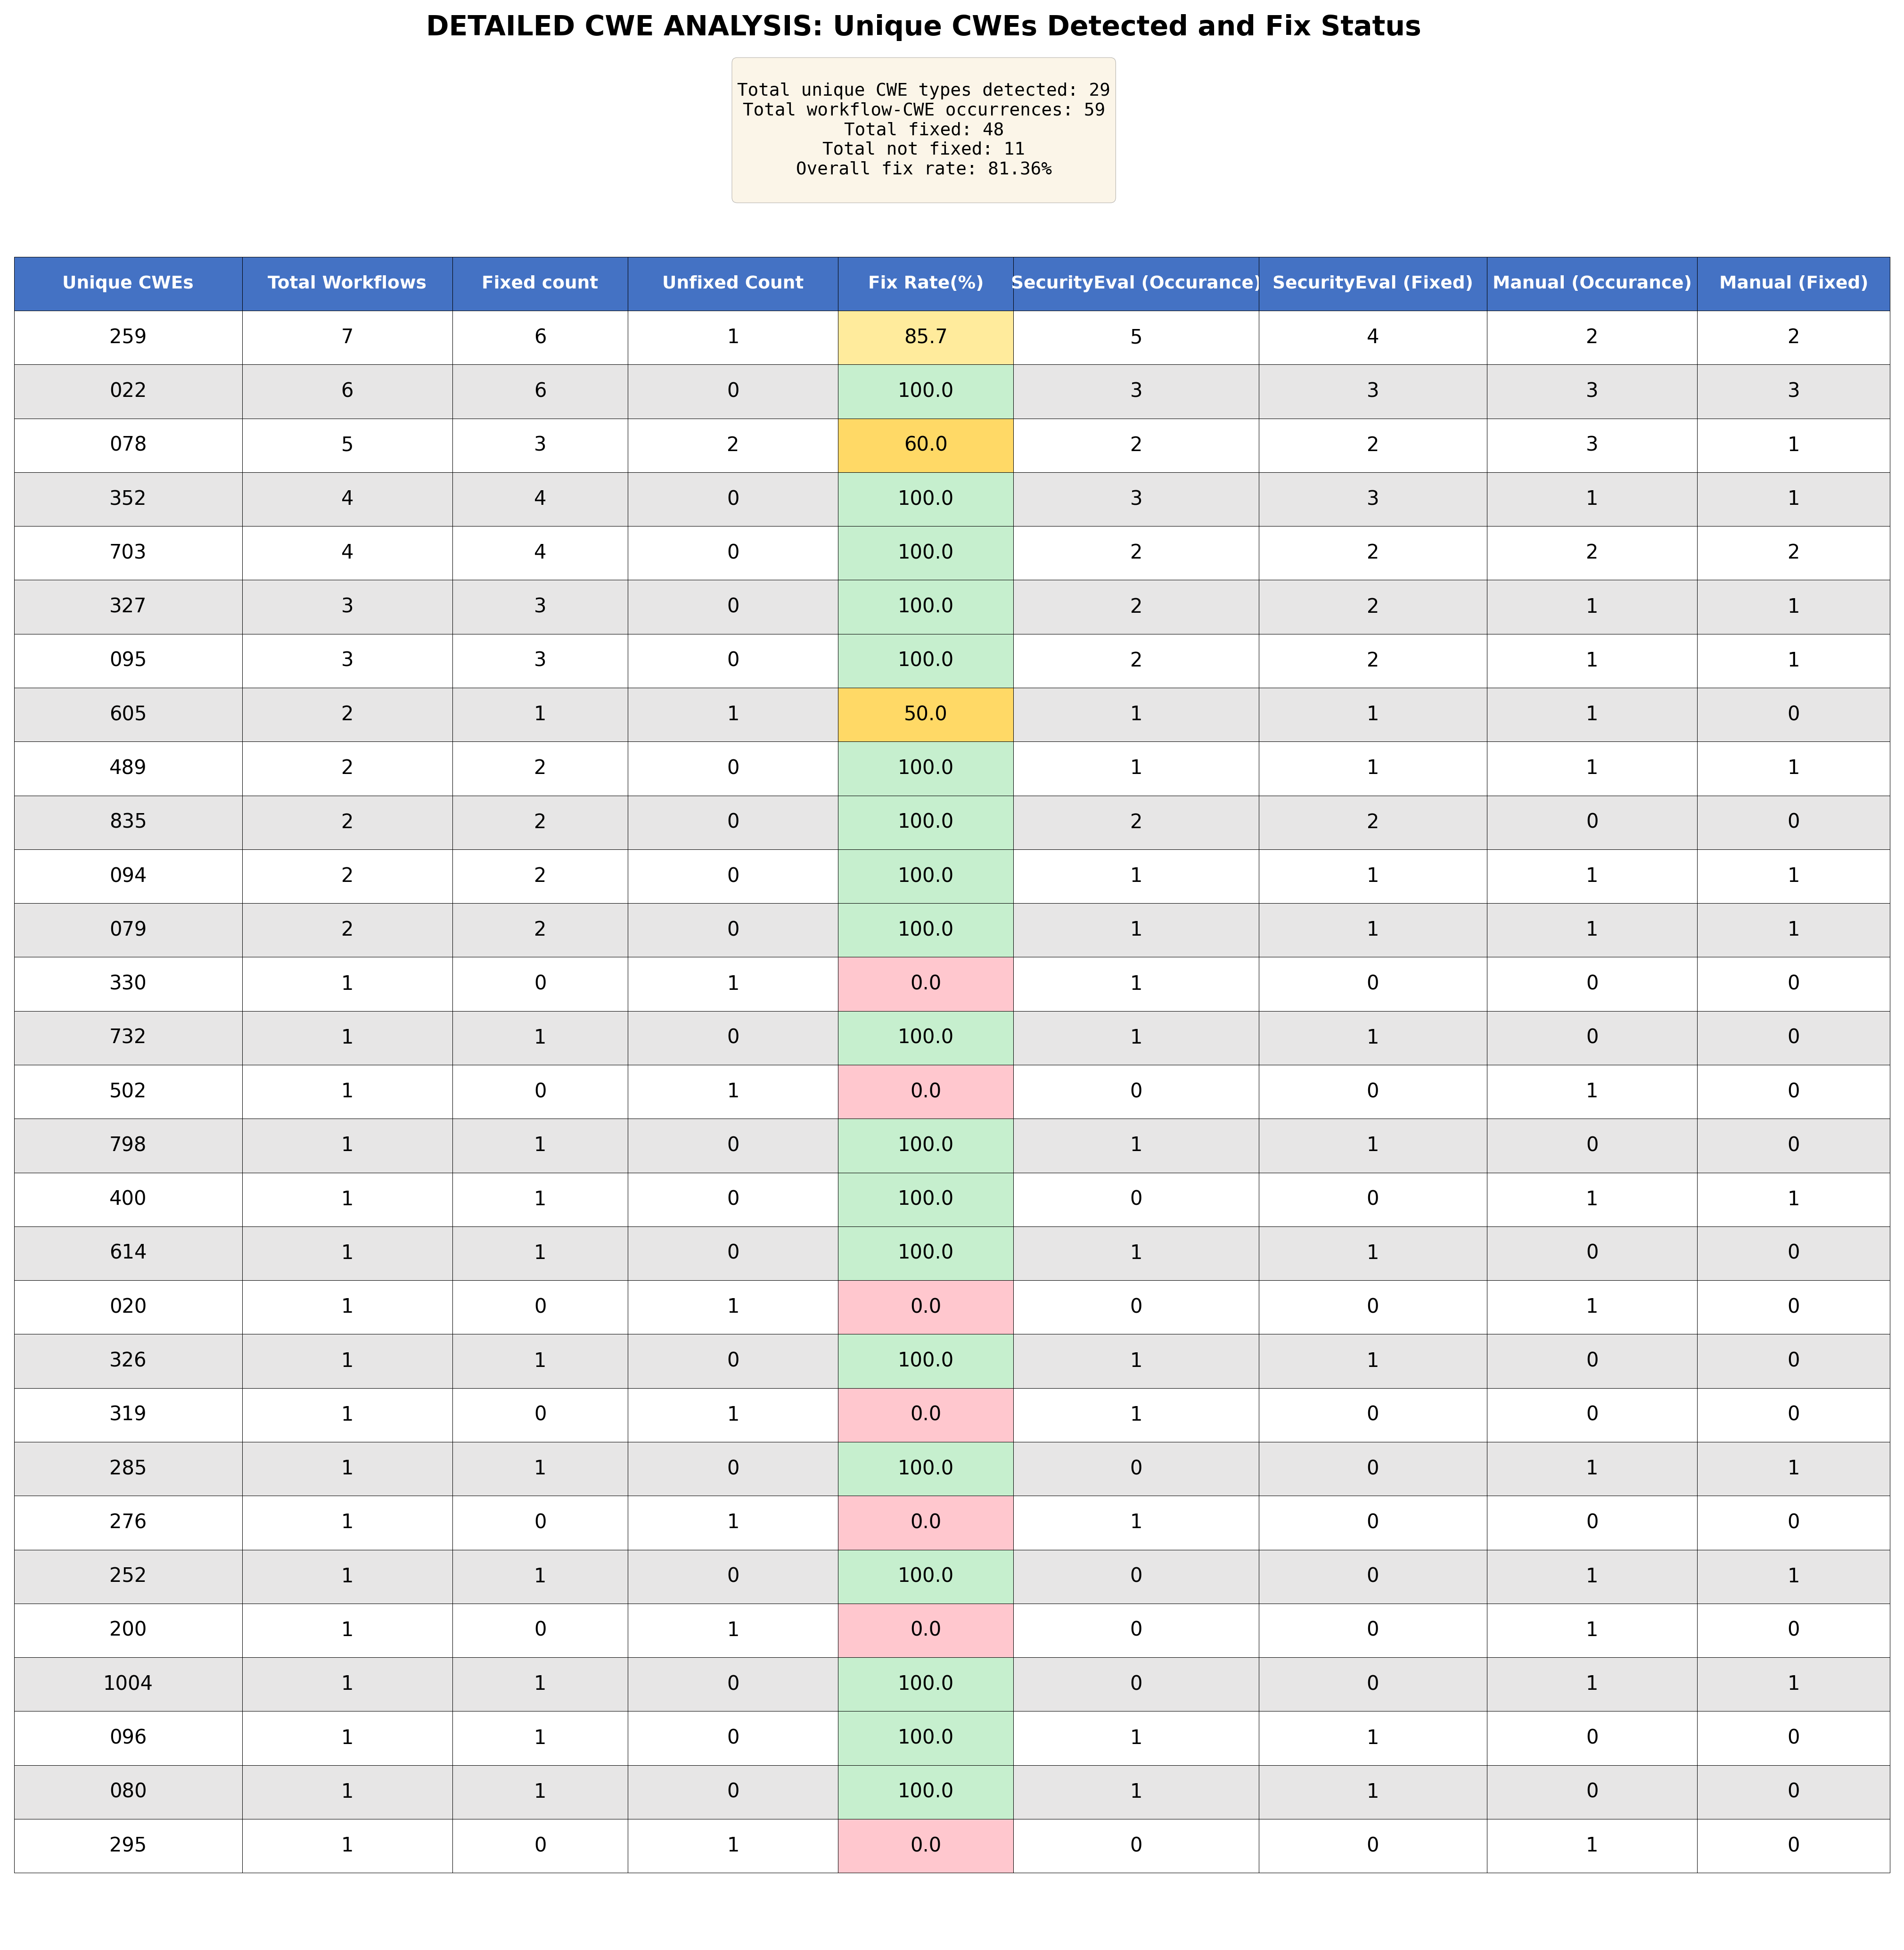

✓ Detailed CWE analysis table saved as image: data/cwe_detailed_analysis_table.png


In [7]:
# Export Detailed CWE Analysis Table as Image
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

fig, ax = plt.subplots(figsize=(16, 14))
ax.axis('tight')
ax.axis('off')

# Title and summary statistics
title_text = "DETAILED CWE ANALYSIS: Unique CWEs Detected and Fix Status"
summary_text = f"""
Total unique CWE types detected: {len(cwe_details_df)}
Total workflow-CWE occurrences: {int(cwe_details_df['Total Workflows'].sum())}
Total fixed: {int(cwe_details_df['Fixed count'].sum())}
Total not fixed: {int(cwe_details_df['Unfixed Count'].sum())}
Overall fix rate: {(cwe_details_df['Fixed count'].sum() / cwe_details_df['Total Workflows'].sum() * 100):.2f}%
"""

# Add title
fig.text(0.5, 0.98, title_text, ha='center', fontsize=14, fontweight='bold')
fig.text(0.5, 0.90, summary_text, ha='center', fontsize=9, 
         family='monospace', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.3))

# Prepare table data
table_data = []
table_data.append(list(cwe_details_df.columns))  # Headers

# Add all rows
for idx, row in cwe_details_df.iterrows():
    table_data.append([
        row['Unique CWEs'],
        int(row['Total Workflows']),
        int(row['Fixed count']),
        int(row['Unfixed Count']),
        f"{row['Fix Rate(%)']:.1f}",
        int(row['SecurityEval (Occurance)']),
        int(row['SecurityEval (Fixed)']),
        int(row['Manual (Occurance)']),
        int(row['Manual (Fixed)'])
    ])

# Create table
table = ax.table(cellText=table_data, cellLoc='center', loc='center',
                colWidths=[0.13, 0.12, 0.10, 0.12, 0.10, 0.14, 0.13, 0.12, 0.11])

table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1, 2)

# Style header row
for i in range(len(table_data[0])):
    cell = table[(0, i)]
    cell.set_facecolor('#4472C4')
    cell.set_text_props(weight='bold', color='white', fontsize=9)

# Style data rows with alternating colors
for i in range(1, len(table_data)):
    for j in range(len(table_data[0])):
        cell = table[(i, j)]
        if i % 2 == 0:
            cell.set_facecolor('#E7E6E6')
        else:
            cell.set_facecolor('white')
        
        # Highlight fix rate colors
        if j == 4:  # Fix Rate(%) column
            fix_rate = float(table_data[i][4])
            if fix_rate == 100:
                cell.set_facecolor('#C6EFCE')  # Dark Green (100%)
            elif fix_rate >= 70:
                cell.set_facecolor('#FFEB9C')  # Yellow (70-99%)
            elif fix_rate > 0:
                cell.set_facecolor('#FFD966')  # Light Orange (1-69%)
            else:
                cell.set_facecolor('#FFC7CE')  # Red (0%)

plt.subplots_adjust(top=0.90, bottom=0.02)
plt.savefig('data/cwe_detailed_analysis_table.png', dpi=300, bbox_inches='tight', facecolor='white')
plt.show()

print("✓ Detailed CWE analysis table saved as image: data/cwe_detailed_analysis_table.png")

## 2. Visualization: Fixed vs Remaining Vulnerabilities

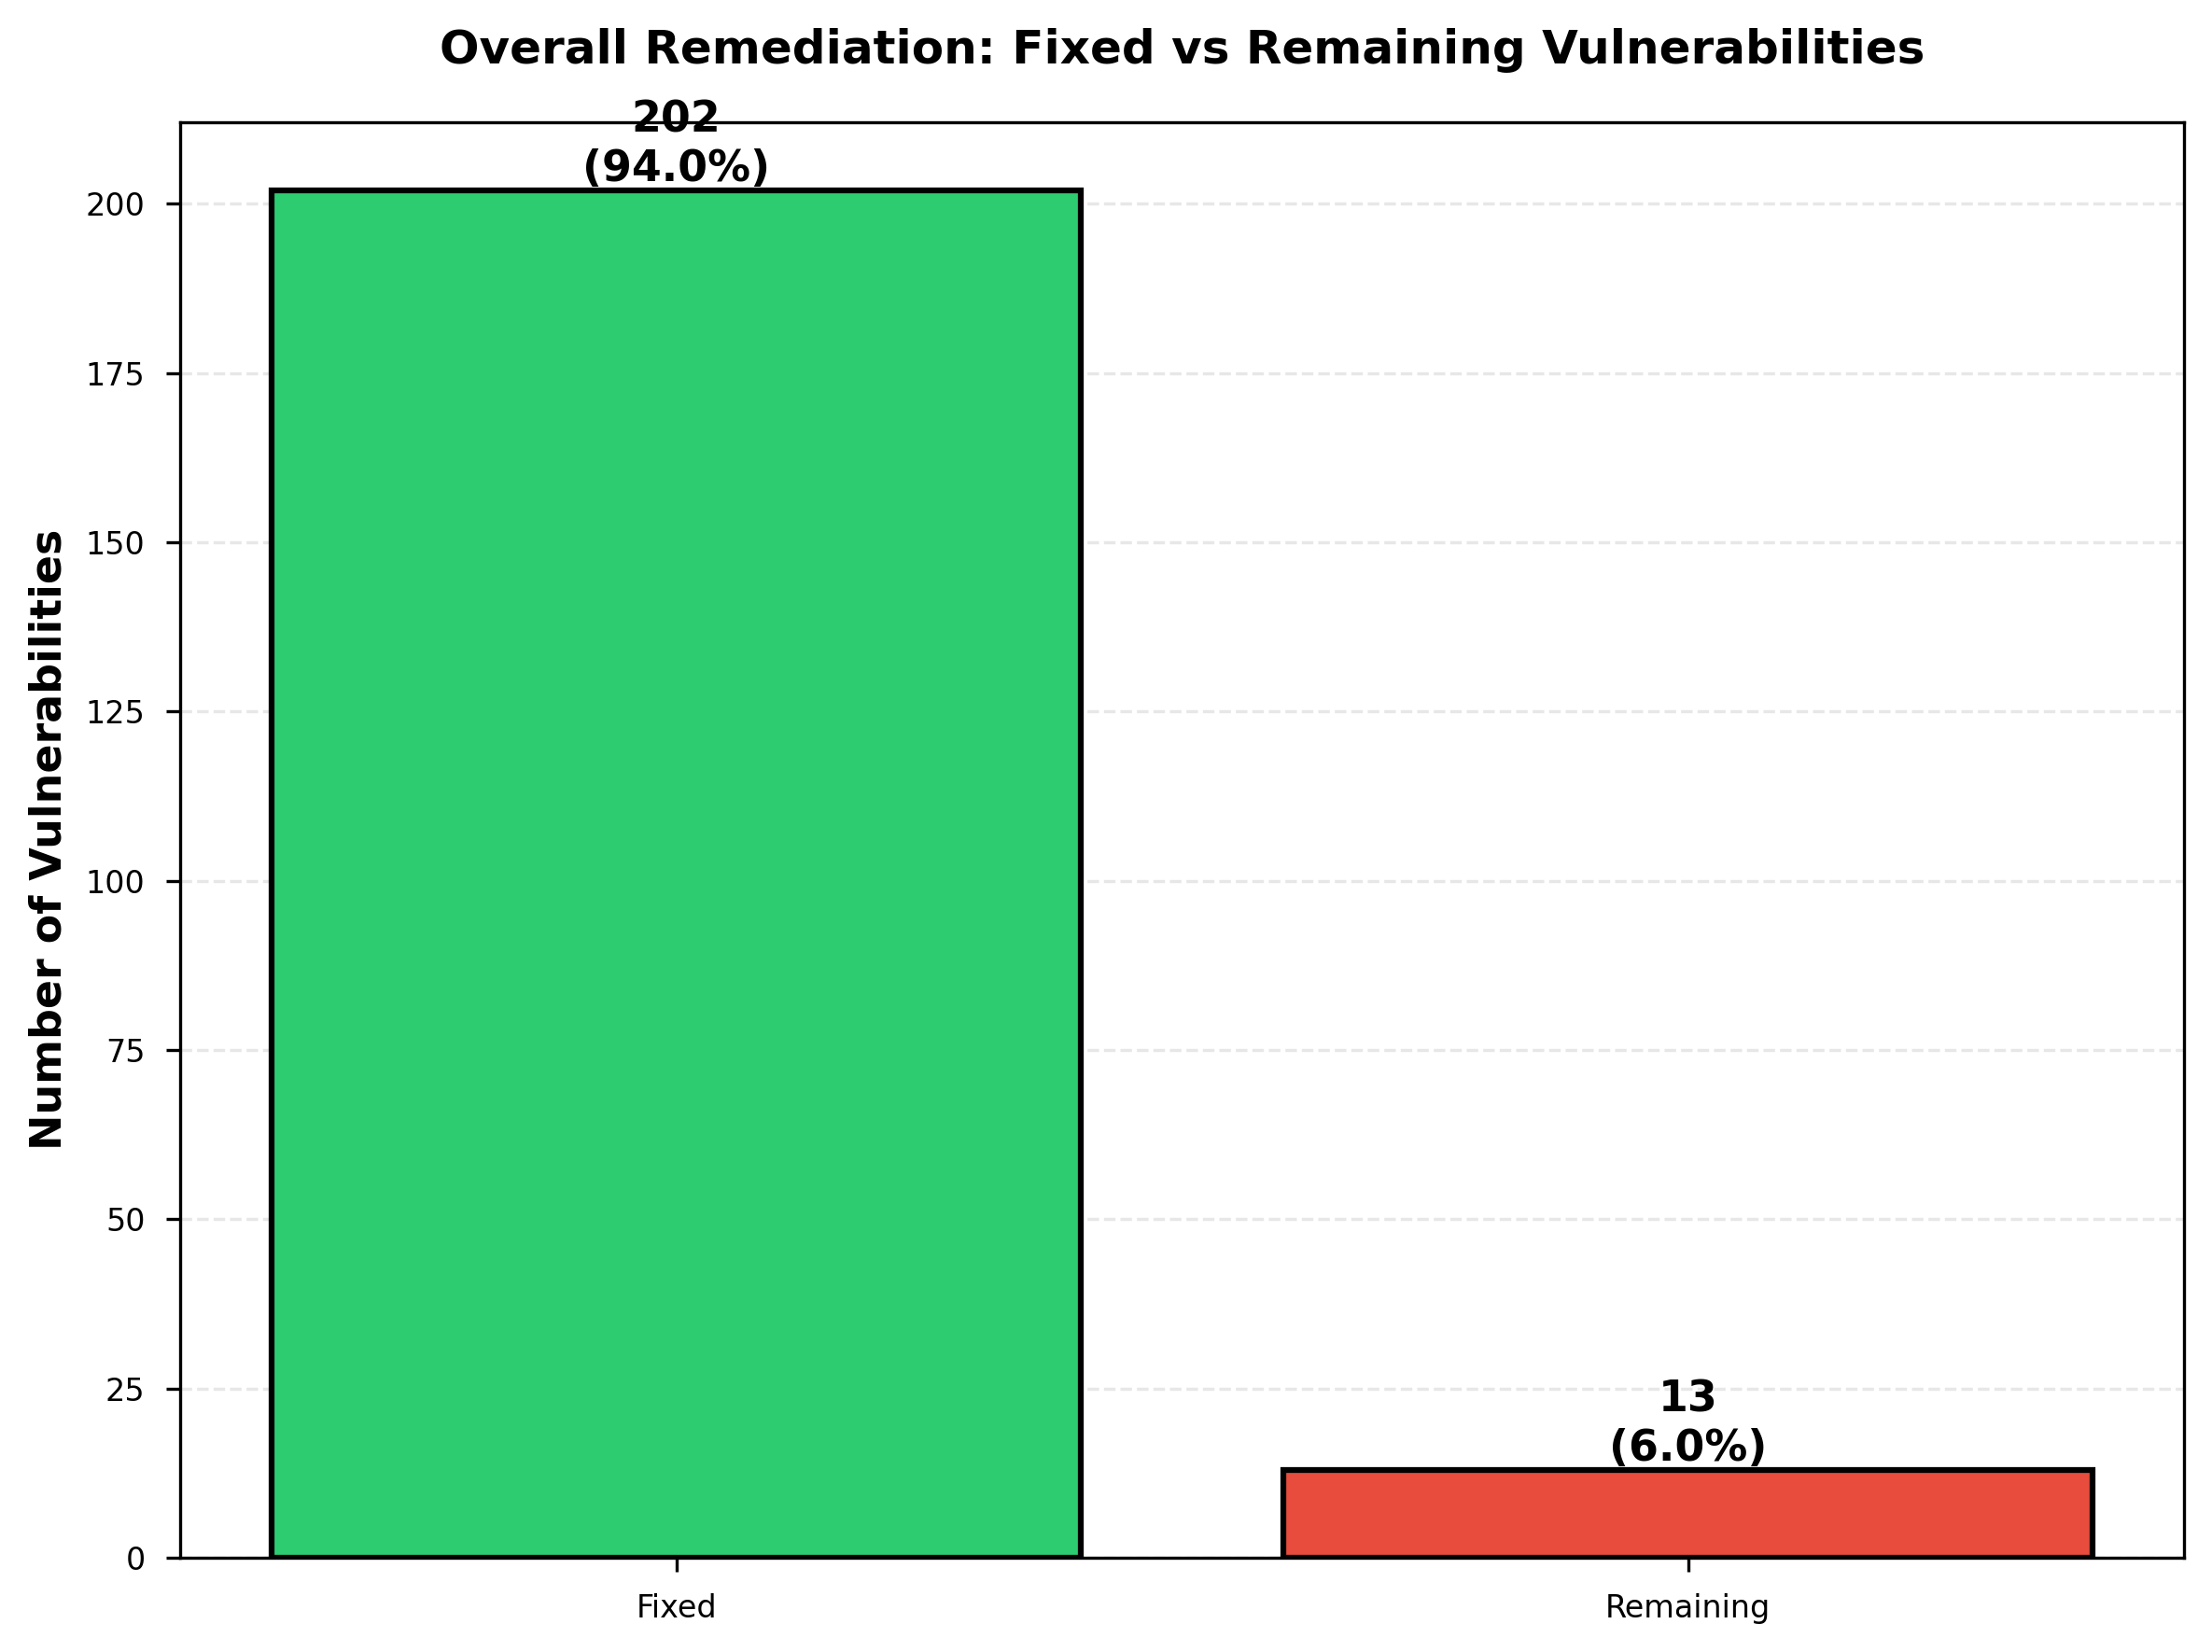

✓ Fixed vs remaining plot saved


In [8]:
# Plot 1: Overall Fixed vs Remaining Vulnerabilities
fig, ax = plt.subplots(figsize=(8, 6))

total_fixed = mitigation_df['total_fixed'].sum()
total_remaining = mitigation_df['total_remaining'].sum()

categories = ['Fixed', 'Remaining']
values = [total_fixed, total_remaining]
colors = ['#2ecc71', '#e74c3c']

bars = ax.bar(categories, values, color=colors, edgecolor='black', linewidth=1.5)

# Add value labels
for bar, val in zip(bars, values):
    height = bar.get_height()
    percentage = (val / sum(values)) * 100
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{int(val)}\n({percentage:.1f}%)',
            ha='center', va='bottom', fontsize=11, fontweight='bold')

ax.set_ylabel('Number of Vulnerabilities', fontsize=11, fontweight='bold')
ax.set_title('Overall Remediation: Fixed vs Remaining Vulnerabilities', 
             fontsize=12, fontweight='bold', pad=15)
ax.grid(axis='y', alpha=0.3, linestyle='--')
ax.set_axisbelow(True)

plt.tight_layout()
plt.savefig('data/mitigation_fixed_vs_remaining.png', bbox_inches='tight')
plt.show()

print("✓ Fixed vs remaining plot saved")

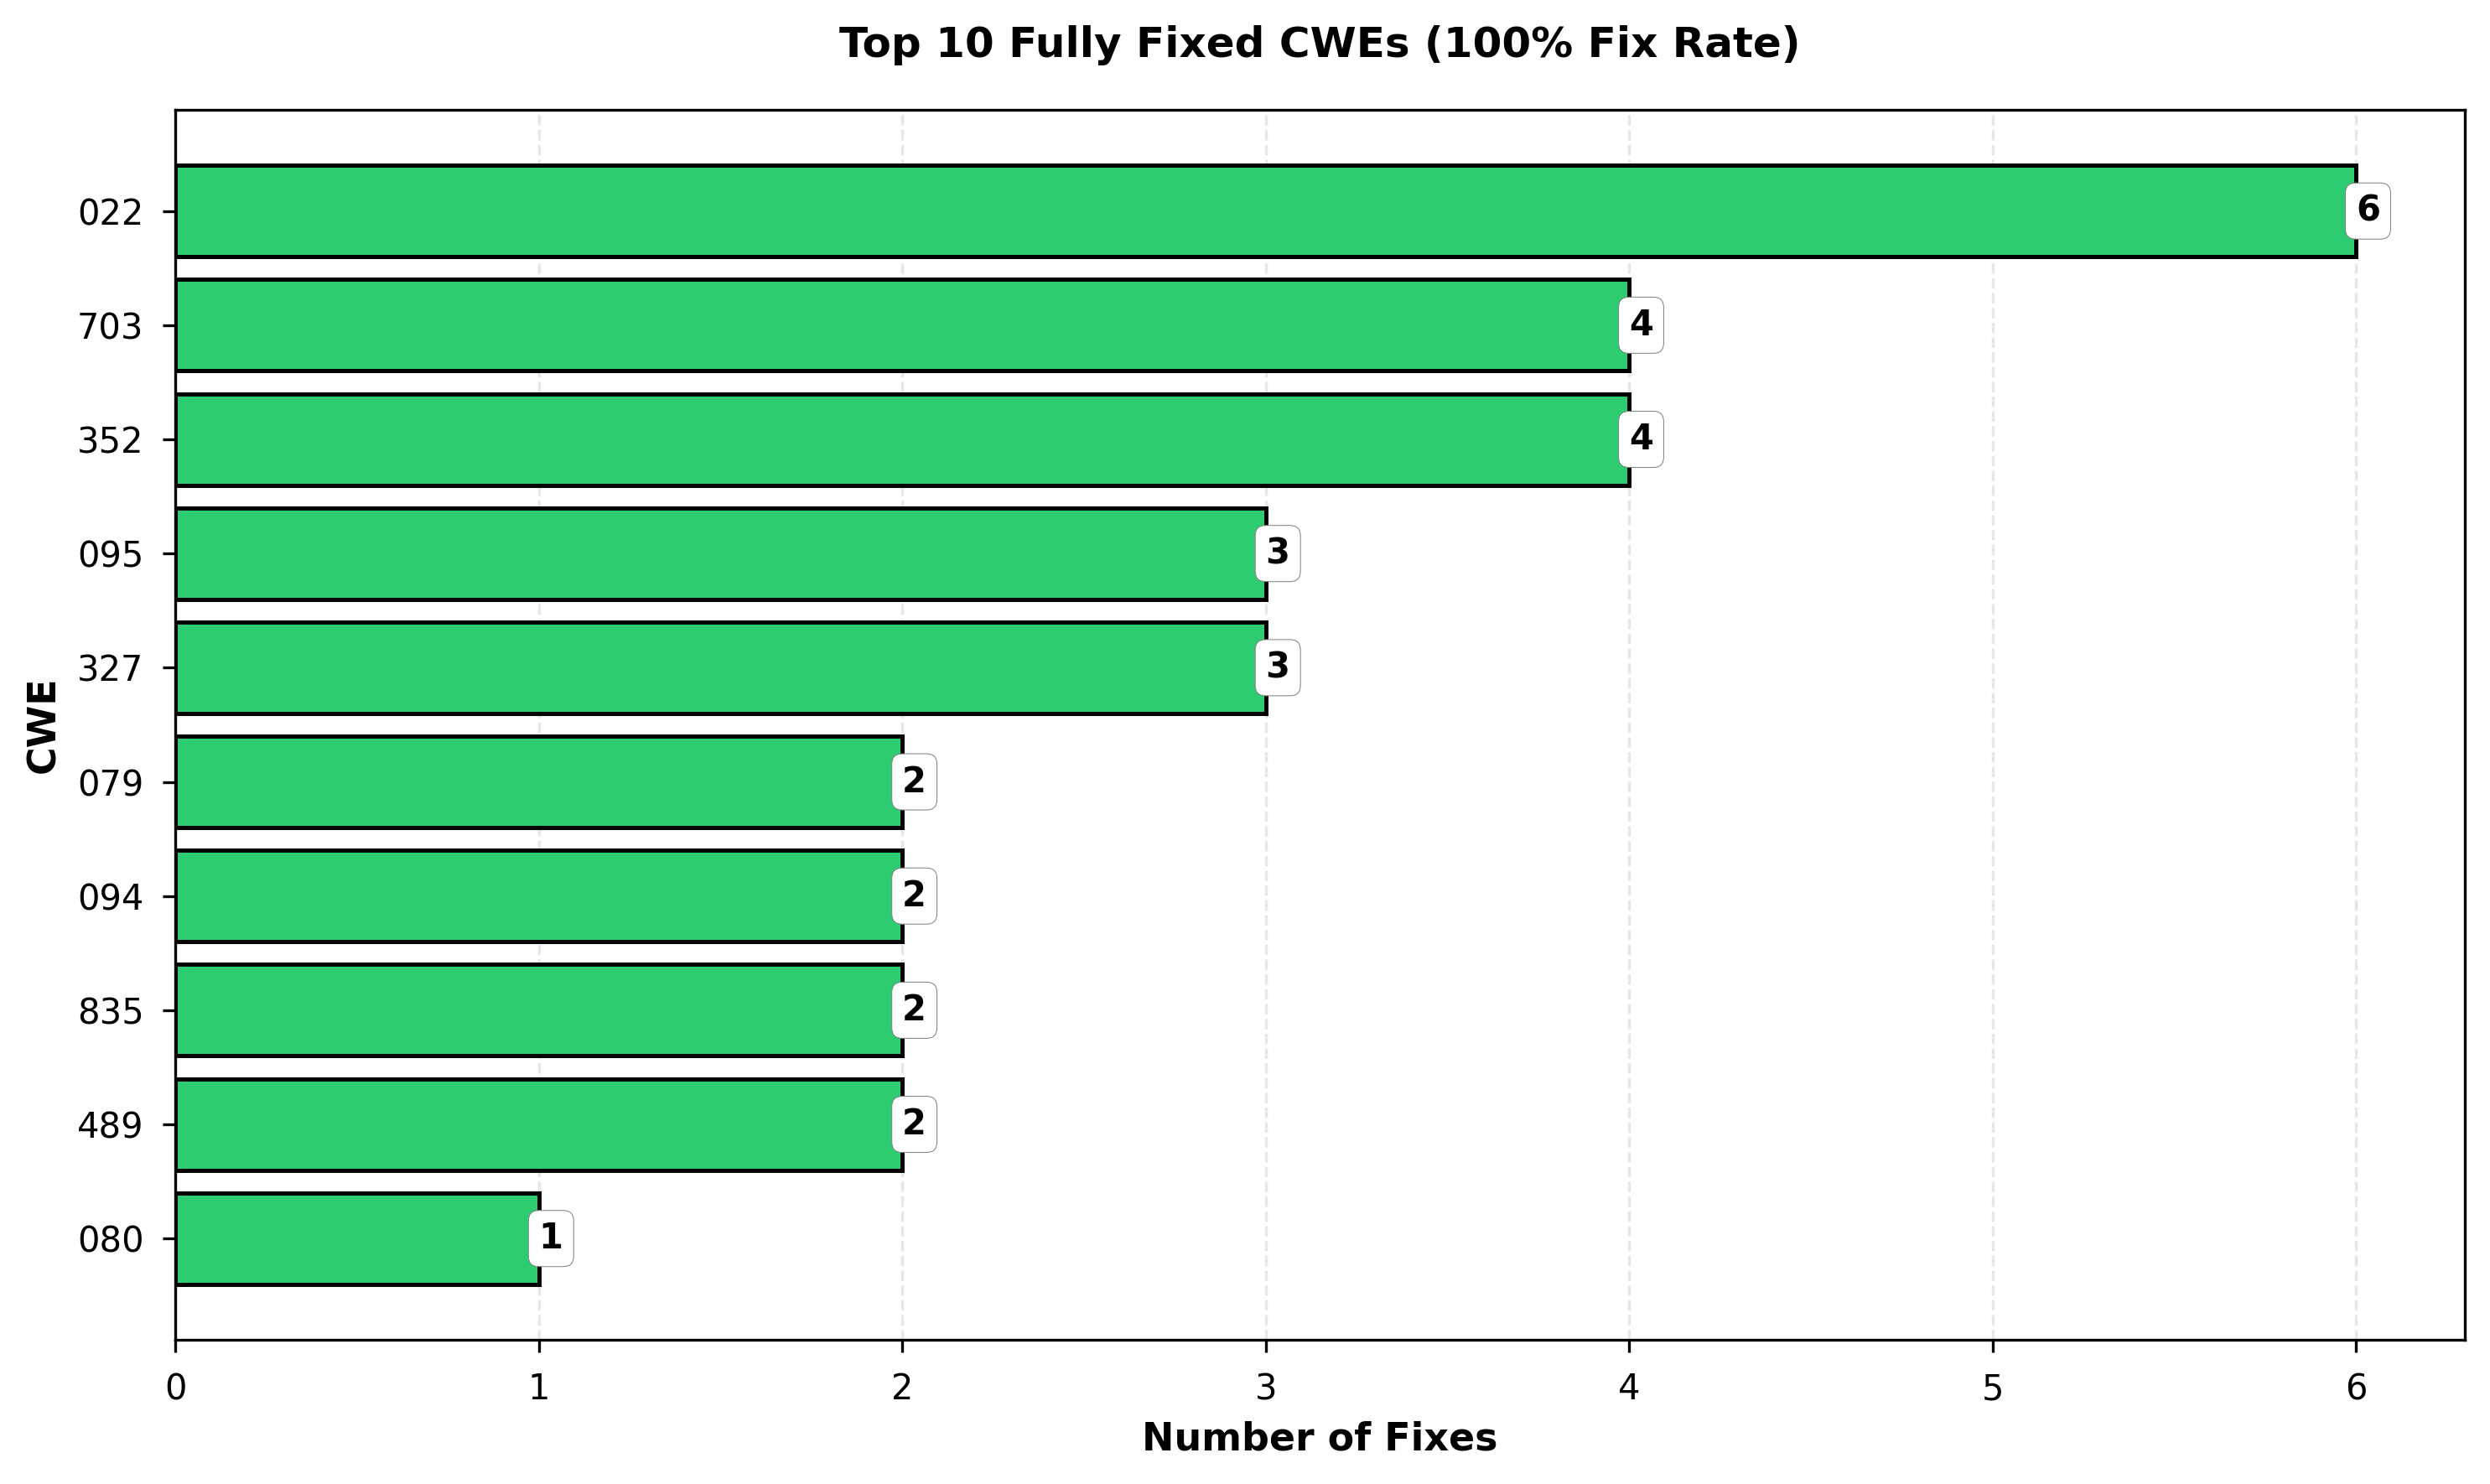

✓ Top fixed CWEs plot saved (filtered to 100% fix rate)


In [11]:
# Plot 3: Top Fixed CWEs (100% Fix Rate Only)
# Build list of all fixed CWEs across workflows
all_fixed_cwes = []
for cwes in mitigation_df['fixed_cwes_list']:
    all_fixed_cwes.extend(cwes)

# Determine CWEs that achieved 100% fix rate using cwe_details_df
fully_fixed_cwe_set = set(
    cwe_details_df[cwe_details_df['Fix Rate(%)'] == 100]['Unique CWEs'].astype(str)
)

# Filter to only 100% fix-rate CWEs
filtered_fixed_cwes = [c for c in all_fixed_cwes if c in fully_fixed_cwe_set]

fixed_cwe_counts = Counter(filtered_fixed_cwes)
top_fixed = dict(fixed_cwe_counts.most_common(10))

if top_fixed:
    fig, ax = plt.subplots(figsize=(10, 6))
    
    cwes = list(top_fixed.keys())
    counts = list(top_fixed.values())
    
    bars = ax.barh(range(len(cwes)), counts, color='#2ecc71', 
                   edgecolor='black', linewidth=1.2)
    
    # Add value labels
    for bar, val in zip(bars, counts):
        width = bar.get_width()
        ax.text(width, bar.get_y() + bar.get_height()/2.,
                f'{int(val)}',
                ha='left', va='center', fontsize=10, fontweight='bold', 
                bbox=dict(boxstyle='round,pad=0.3', facecolor='white', edgecolor='gray'))
    
    ax.set_yticks(range(len(cwes)))
    ax.set_yticklabels(cwes, fontsize=10)
    ax.set_xlabel('Number of Fixes', fontsize=11, fontweight='bold')
    ax.set_ylabel('CWE', fontsize=11, fontweight='bold')
    ax.set_title('Top 10 Fully Fixed CWEs (100% Fix Rate)', fontsize=12, fontweight='bold', pad=15)
    
    # Set x-axis to show integer ticks starting from 0
    max_count = int(max(counts))
    ax.set_xticks(range(0, max_count + 1))
    ax.set_xticklabels(range(0, max_count + 1), fontsize=10)
    
    ax.grid(axis='x', alpha=0.3, linestyle='--')
    ax.set_axisbelow(True)
    ax.invert_yaxis()
    
    plt.tight_layout()
    plt.savefig('data/mitigation_top_fixed_cwes.png', bbox_inches='tight')
    plt.show()
    
    print("✓ Top fixed CWEs plot saved (filtered to 100% fix rate)")
else:
    print("No fully fixed CWEs (100% fix rate) found to plot")

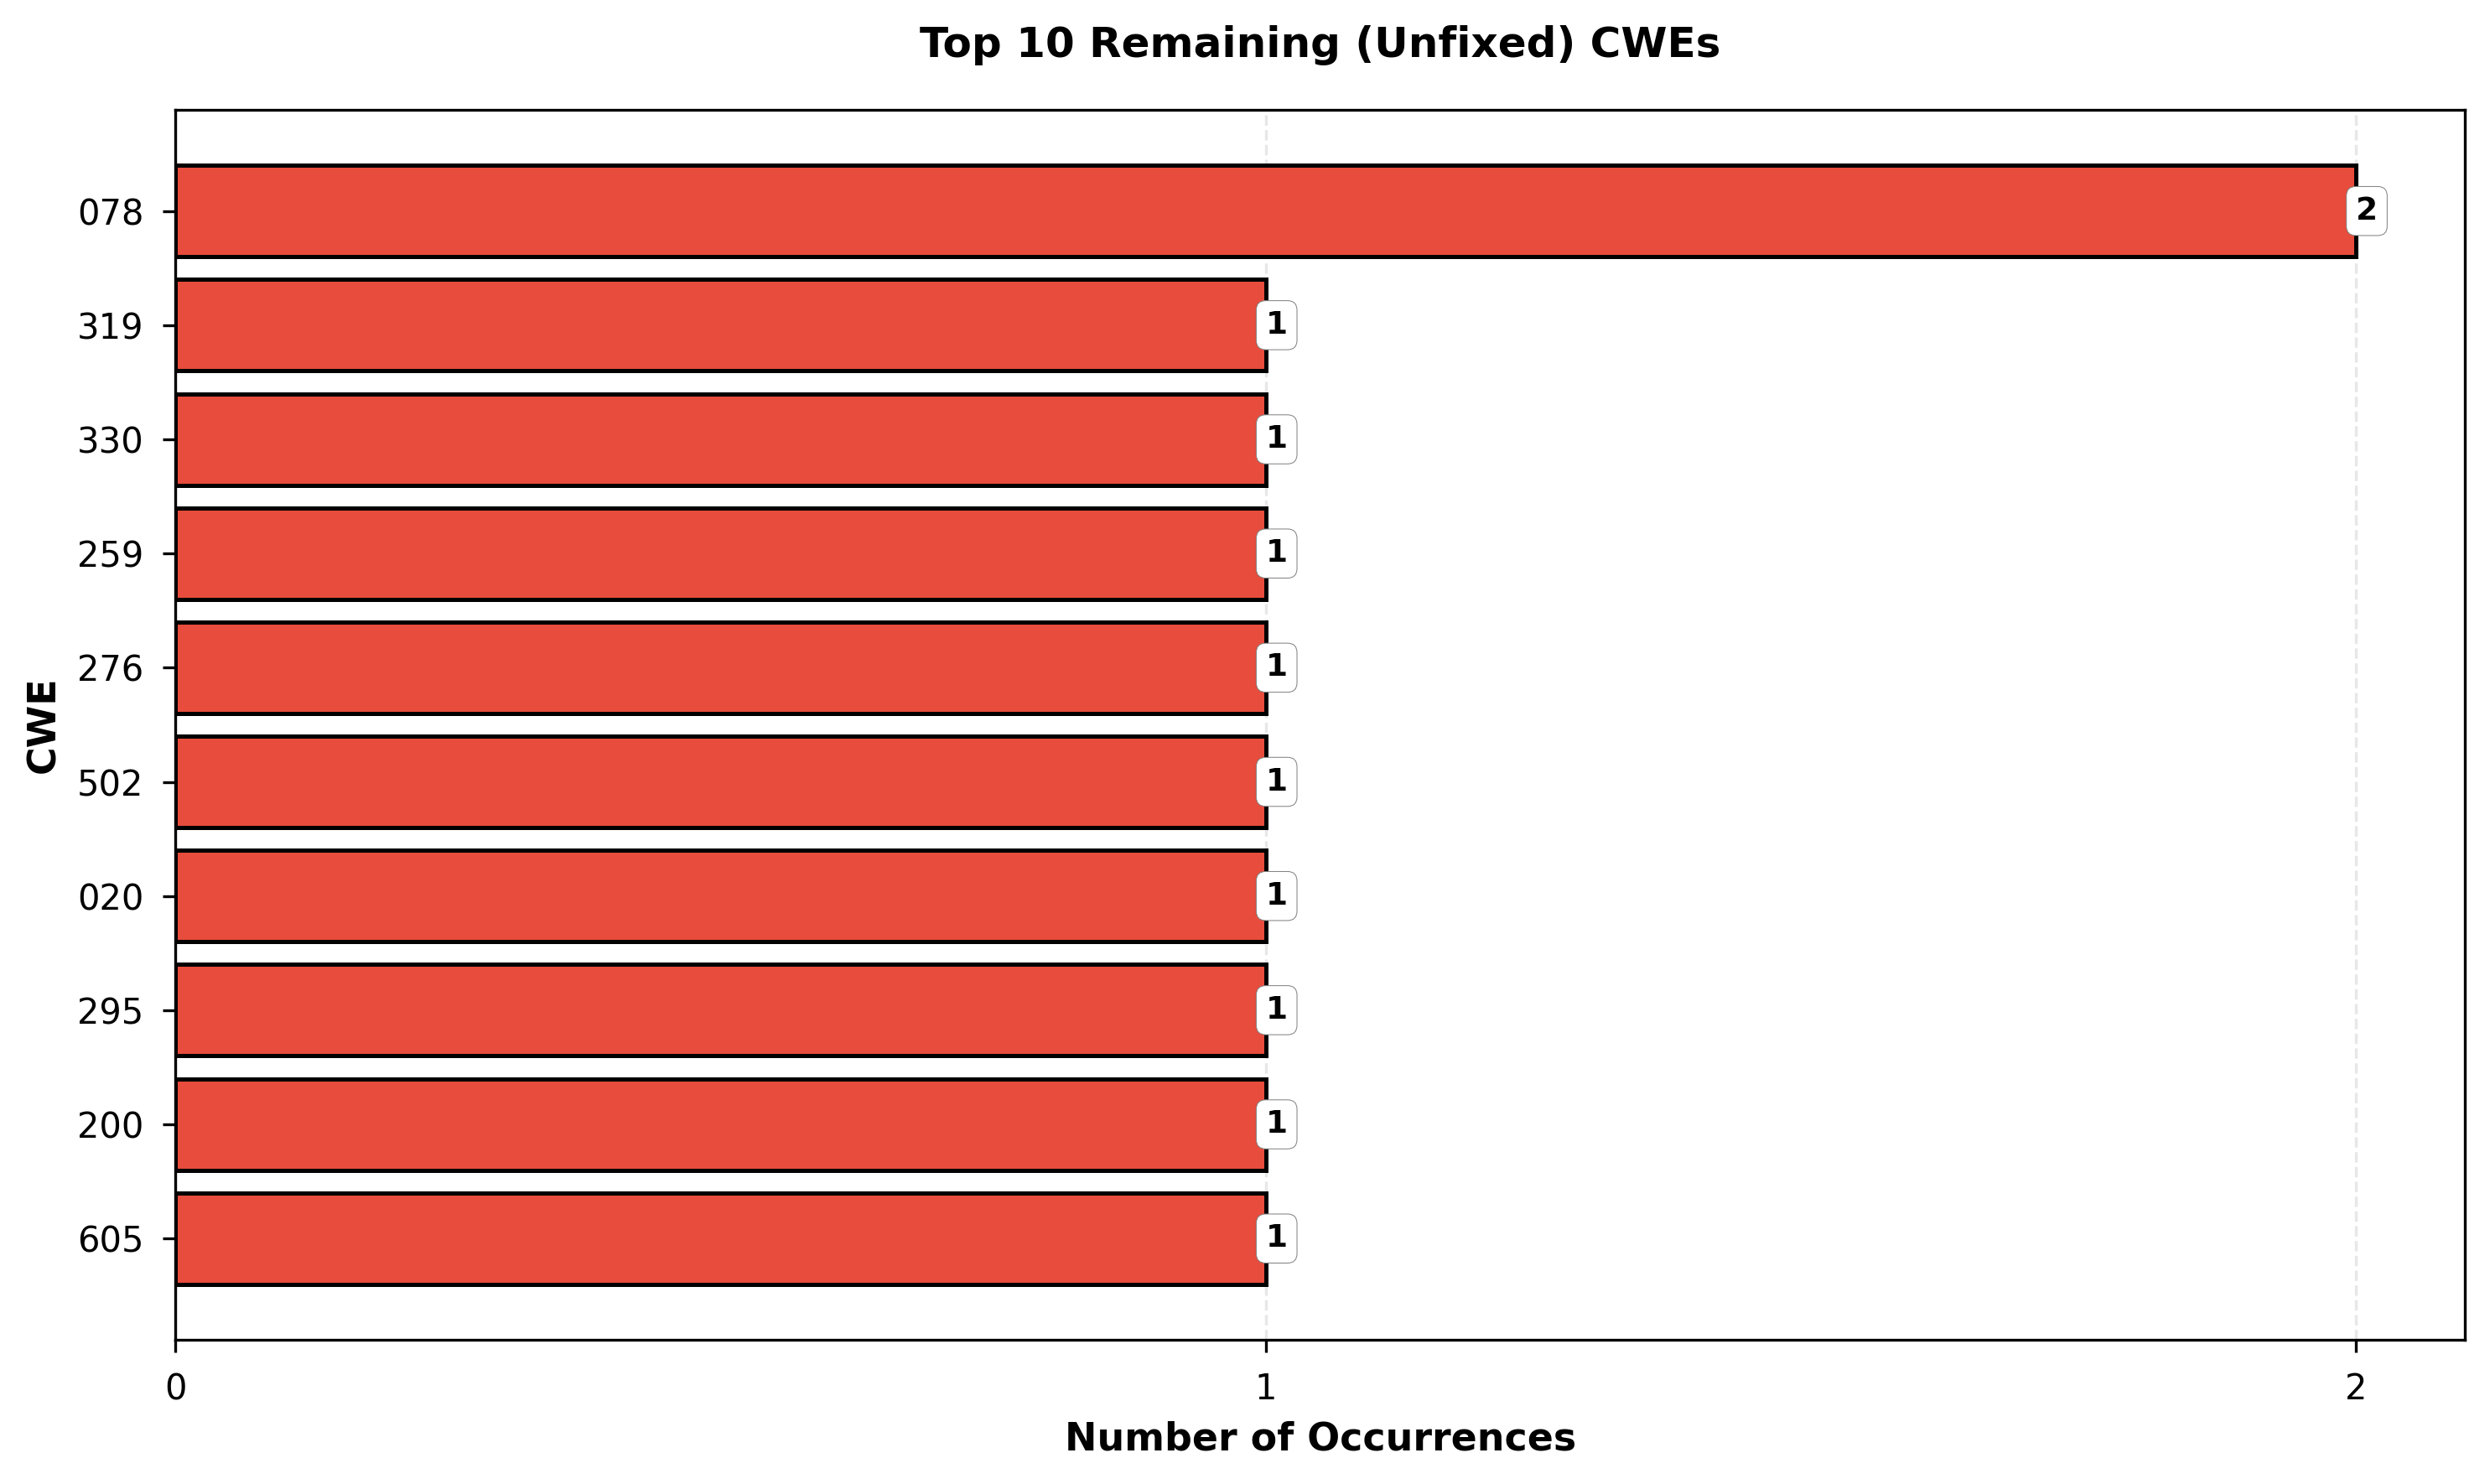

✓ Top remaining CWEs plot saved


In [10]:
# Plot 4: Top Remaining CWEs
all_remaining_cwes = []
for cwes in mitigation_df['remaining_cwes_list']:
    all_remaining_cwes.extend(cwes)

remaining_cwe_counts = Counter(all_remaining_cwes)
top_remaining = dict(remaining_cwe_counts.most_common(10))

if top_remaining:
    fig, ax = plt.subplots(figsize=(10, 6))
    
    cwes = list(top_remaining.keys())
    counts = list(top_remaining.values())
    
    bars = ax.barh(range(len(cwes)), counts, color='#e74c3c', 
                   edgecolor='black', linewidth=1.2)
    
    # Add value labels
    for bar, val in zip(bars, counts):
        width = bar.get_width()
        ax.text(width, bar.get_y() + bar.get_height()/2.,
                f'{int(val)}',
                ha='left', va='center', fontsize=9, fontweight='bold',
                bbox=dict(boxstyle='round,pad=0.3', facecolor='white', edgecolor='gray'))
    
    ax.set_yticks(range(len(cwes)))
    ax.set_yticklabels(cwes, fontsize=10)
    ax.set_xlabel('Number of Occurrences', fontsize=11, fontweight='bold')
    ax.set_ylabel('CWE', fontsize=11, fontweight='bold')
    ax.set_title('Top 10 Remaining (Unfixed) CWEs', fontsize=12, fontweight='bold', pad=15)
    
    # Set x-axis to show integer ticks starting from 0
    max_count = int(max(counts))
    ax.set_xticks(range(0, max_count + 1))
    ax.set_xticklabels(range(0, max_count + 1), fontsize=10)
    
    ax.grid(axis='x', alpha=0.3, linestyle='--')
    ax.set_axisbelow(True)
    ax.invert_yaxis()
    
    plt.tight_layout()
    plt.savefig('data/mitigation_top_remaining_cwes.png', bbox_inches='tight')
    plt.show()
    
    print("✓ Top remaining CWEs plot saved")
else:
    print("No remaining CWEs found to plot")